In [117]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
#import matplotlib.pyplot as plt


verzeichnis = "Untitled Folder"
dateien = [f for f in os.listdir(verzeichnis) if f.endswith('.json')]

alle_daten = []


c:\Users\unger\OneDrive\Dokumente\SebsDocu2025\Jupyter


In [118]:
alle_daten = []

for datei in dateien:
    pfad = os.path.join(verzeichnis, datei)

    # Anbietername aus dem Teil vor dem ersten "_"
    anbietername = datei.split("_")[0].lower()

    # Nur zulässige Anbieter behalten
    if anbietername not in ['aws', 'azure', 'gcp']:
        print(f"⏭️ Datei übersprungen (ungültiger Anbietername): {datei}")
        continue

    if "cold" in datei.lower():
        aufruftyp = "cold"
    elif "warm" in datei.lower():
        aufruftyp = "warm"
    else:
        aufruftyp = "unbekannt"
        
    experiment_code_match = re.search(r'(\d{3})', datei)
    experiment_code = experiment_code_match.group(1) if experiment_code_match else "unbekannt"

    try:
        with open(pfad, 'r', encoding='utf-8') as f:
            data = json.load(f)

        for invocations in data.get("_invocations", {}).values():
            for req_id, details in invocations.items():
                result = details.get("output", {}).get("result", {})
                messung = result.get("measurement")
                if not messung:
                    continue

                zeit = details.get("times", {}).get("client_begin")

                alle_daten.append({
                    "anbieter": anbietername,
                    "aufruf": aufruftyp,
                    "experiment": experiment_code,
                    "datei": datei,
                    "request_id": req_id,
                    "zeit": zeit,
                    "compute_time": messung.get("compute_time"),
                    "download_time": messung.get("download_time"),
                    "upload_time": messung.get("upload_time"),
                    "benchmark_time": details.get("times", {}).get("benchmark"),
                    "client_time": details.get("times", {}).get("client"),
                    "failure": details.get("stats", {}).get("failure", None),
                })

    except Exception as e:
        print(f"!!! Fehler beim Einlesen von {datei}: {e}")

# DataFrame erstellen
df = pd.DataFrame(alle_daten)
df['zeit'] = pd.to_datetime(df['zeit'], errors='coerce')

!!! Fehler beim Einlesen von aws_us_110_cold_results_256.json: Expecting value: line 1 column 1 (char 0)


In [119]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


messwerte = ['compute_time', 'download_time', 'upload_time']
df_clean = remove_outliers_iqr(df, messwerte)

# Vorschau
df_clean.tail()
df_clean.head()

,anbieter,aufruf,experiment,datei,request_id,zeit,compute_time,download_time,upload_time,benchmark_time,client_time,failure
0,aws,cold,120,aws_eu_120_cold_results_1024.json,0079dac3-9e19-4ae0-8881-98de402be653,2025-05-21 18:53:00.603253,56789.0,0.0,71493.0,769681,1408818,False
1,aws,cold,120,aws_eu_120_cold_results_1024.json,018435df-5786-4fcd-b3f6-78cfa8a8d23a,2025-05-21 18:53:14.346679,57285.0,0.0,188160.0,888698,1483307,False
2,aws,cold,120,aws_eu_120_cold_results_1024.json,037e656c-7eef-466b-9ca6-2bab7466746d,2025-05-21 18:51:52.453246,58201.0,0.0,72474.0,719602,1359657,False
3,aws,cold,120,aws_eu_120_cold_results_1024.json,03c8baad-9954-4967-bf76-f2d2ce8c55ec,2025-05-21 18:49:22.546482,55809.0,0.0,258690.0,895174,1498470,False
4,aws,cold,120,aws_eu_120_cold_results_1024.json,04fca20e-b91c-4062-8492-ecd2cbe0b500,2025-05-21 18:52:46.960447,55763.0,0.0,133488.0,793549,1427841,False


In [120]:
def iqr_outlier_filter(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

df['outlier_compute'] = iqr_outlier_filter(df['compute_time'])
df['outlier_download'] = iqr_outlier_filter(df['download_time'])
df['outlier_upload'] = iqr_outlier_filter(df['upload_time'])

df_ausreisser = df[df[['outlier_compute', 'outlier_download', 'outlier_upload']].any(axis=1)]

df_ausreisser[['anbieter', 'zeit', 'compute_time', 'download_time', 'upload_time', 'datei']]


,anbieter,zeit,compute_time,download_time,upload_time,datei
2418,aws,2025-05-22 13:09:02.942459,17523270.0,816899.0,237185.0,aws_eu_220_cold_results_256.json
2419,aws,2025-05-22 13:04:25.241345,17360805.0,840541.0,196095.0,aws_eu_220_cold_results_256.json
2420,aws,2025-05-22 13:07:19.193461,17223698.0,877471.0,161597.0,aws_eu_220_cold_results_256.json
2421,aws,2025-05-22 13:04:25.241241,17122635.0,799007.0,262975.0,aws_eu_220_cold_results_256.json
2422,aws,2025-05-22 13:10:12.547957,17383908.0,798321.0,249016.0,aws_eu_220_cold_results_256.json
...,...,...,...,...,...,...
18772,gcp,2025-05-22 19:54:00.845493,1725521.0,1637901.0,821386.0,gcp_311_warm_results_512.json
18773,gcp,2025-05-22 19:49:19.477602,1622990.0,1785356.0,826292.0,gcp_311_warm_results_512.json
18774,gcp,2025-05-22 19:50:13.165251,1834202.0,1758482.0,888826.0,gcp_311_warm_results_512.json
18775,gcp,2025-05-22 19:56:23.711266,1502601.0,1886123.0,1094507.0,gcp_311_warm_results_512.json


In [121]:
print(df_clean['anbieter'].value_counts())


anbieter
aws      10075
gcp       3414
azure     2388
Name: count, dtype: int64


In [122]:
# Nach dataframes nach 'aufruf' (warm/kalt) sortieren
df_clean = df_clean.sort_values(by=["aufruf", "experiment"])
# Optional: Index zurücksetzen
df_clean = df_clean.reset_index(drop=True)
# Vorschau
df_clean.head()

# data frame für kalte und warme starts
df_cold = df_clean[df_clean['aufruf'] == 'cold']
df_warm = df_clean[df_clean['aufruf'] == 'warm']
#df_cold.head()
#df_warm.head()



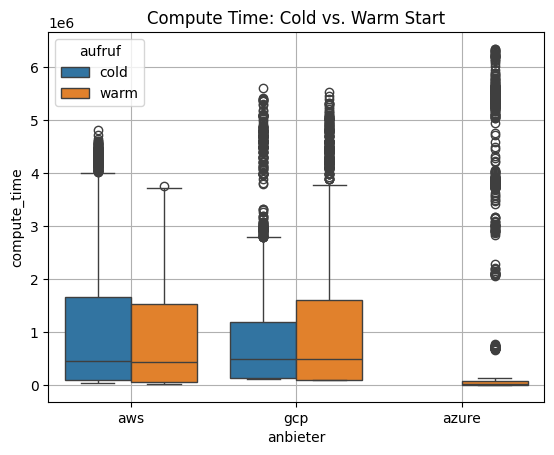

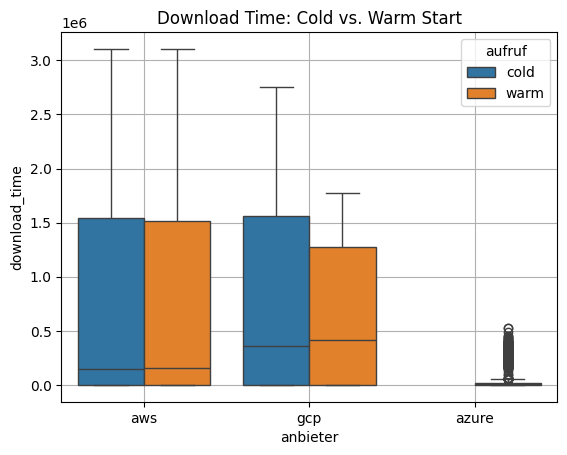

In [123]:
sns.boxplot(data=df_clean, x="anbieter", y="compute_time", hue="aufruf")
plt.title("Compute Time: Cold vs. Warm Start")
plt.grid(True)
plt.show()
sns.boxplot(data=df_clean, x="anbieter", y="download_time", hue="aufruf")
plt.title("Download Time: Cold vs. Warm Start")
plt.grid(True)
plt.show()


In [124]:
# Für Performance: times, provider_times, output.begin/end.
# Für Kosten: billing.
# Für Zuverlässigkeit: stats.failure, stats.cold_start.
#Für Ressourcenverbrauch: memory_used.

df_clean[['anbieter', 'aufruf', 'experiment', 'compute_time', 'download_time', 'upload_time', 'failure']].describe()
df_cold[['anbieter', 'aufruf', 'experiment', 'compute_time', 'download_time', 'upload_time', 'failure']].describe()
df_warm[['anbieter', 'aufruf', 'experiment', 'compute_time', 'download_time', 'upload_time', 'failure']].describe()  



,compute_time,download_time,upload_time
count,9.151000e+03,9.151000e+03,9151.000000
mean,9.302258e+05,4.833734e+05,177205.084035
std,1.367171e+06,7.159479e+05,152995.920812
min,1.650000e+02,0.000000e+00,7967.000000
25%,3.577200e+04,0.000000e+00,48865.500000
50%,1.329830e+05,1.943900e+04,138363.000000
75%,1.493377e+06,1.295150e+06,266319.000000
max,6.340494e+06,3.105481e+06,660782.000000


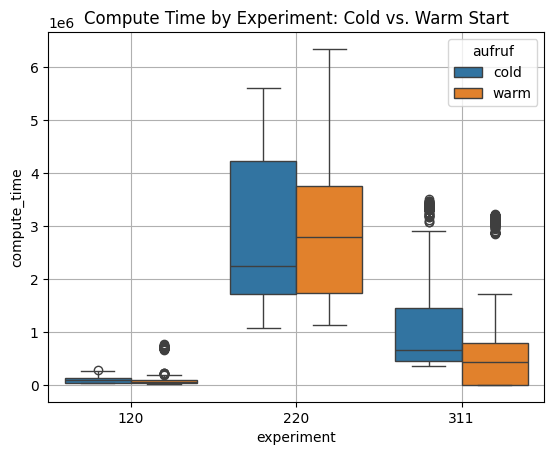

In [125]:
# Boxplot erstellen für warm/kalt und nach experiment sortieren
sns.boxplot(data=df_clean, x="experiment", y="compute_time", hue="aufruf")
plt.title("Compute Time by Experiment: Cold vs. Warm Start")
plt.grid(True)
plt.show()
    


Experiment 120
anbieter
aws      4035
gcp      1626
azure    1014
Name: count, dtype: int64


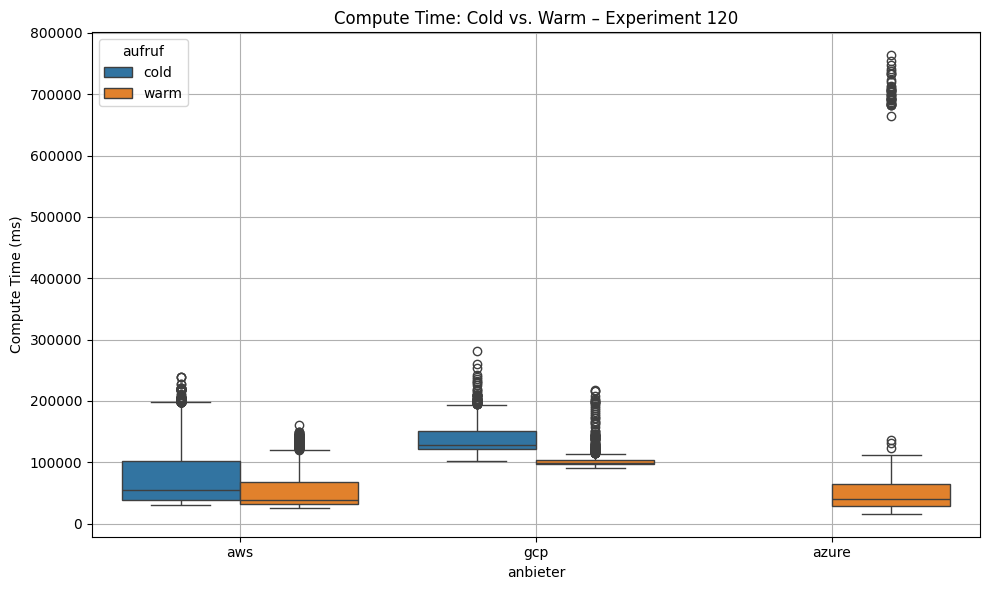


Experiment 220
anbieter
aws      2409
gcp       818
azure     361
Name: count, dtype: int64


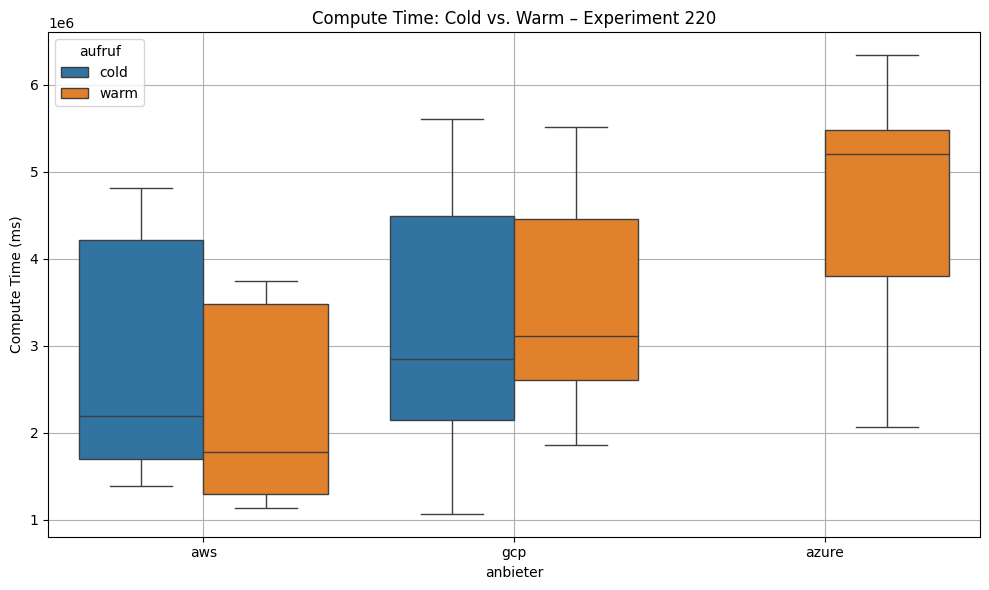


Experiment 311
anbieter
aws      3631
azure    1013
gcp       970
Name: count, dtype: int64


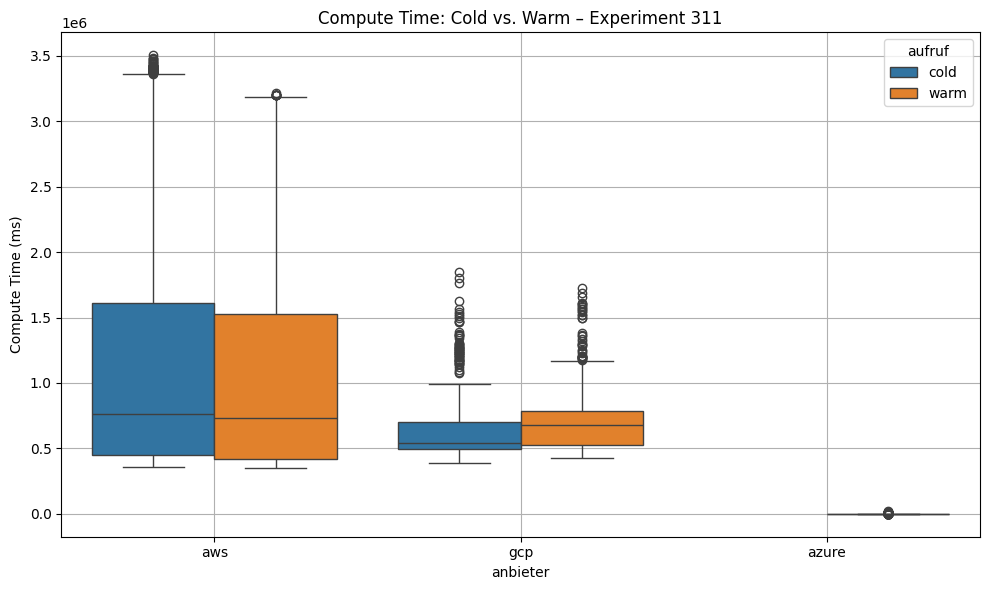

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Alle eindeutigen experiment_code werte sortieren
experimente = sorted(df_clean['experiment'].dropna().unique())

for exp_code in experimente:
    print(f"\nExperiment {exp_code}")
    
    df_exp = df_clean[df_clean['experiment'] == exp_code]
    
    # Anbieterhäufigkeit anzeigen
    print(df_exp['anbieter'].value_counts())
    
    # Boxplot erzeugen (inkl interquartil, median)
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_exp, x="anbieter", y="compute_time", hue="aufruf")
    plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
    plt.ylabel("Compute Time (ms)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


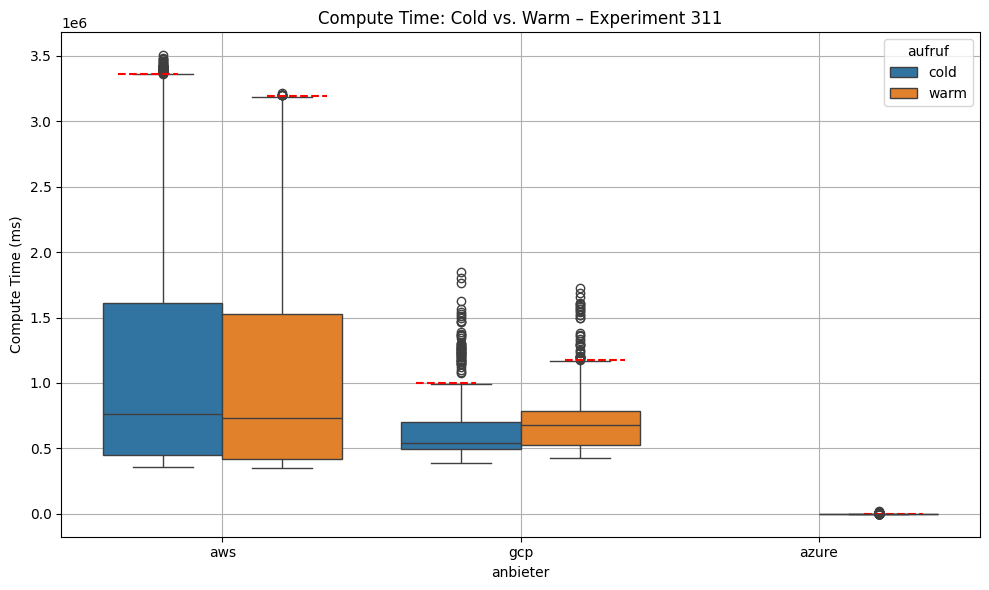

In [127]:
# Berechnung der Schwellenwerte pro gruppe
thresholds = (
    df_exp.groupby(["anbieter", "aufruf"])["compute_time"]
    .apply(lambda x: x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))
    .reset_index(name="threshold")
)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exp, x="anbieter", y="compute_time", hue="aufruf")

# Schwellenwerte einzeichnen
for i, row in thresholds.iterrows():
    anbieter = row["anbieter"]
    aufruf = row["aufruf"]
    thresh = row["threshold"]

    # Position auf der x-Achse finden (entsprechend der Boxplot-Darstellung)
    # Dafür bestimmen wir, wie viele Kategorien es gibt und wo die Linien gezeichnet werden sollen
    hue_levels = df_exp["aufruf"].unique()
    x_base = list(df_exp["anbieter"].unique()).index(anbieter)
    hue_offset = list(hue_levels).index(aufruf) / len(hue_levels) - 0.5 + 1 / (2 * len(hue_levels))
    x_pos = x_base + hue_offset

    plt.hlines(y=thresh, xmin=x_pos - 0.1, xmax=x_pos + 0.1, colors="red", linestyles="--")

plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
plt.ylabel("Compute Time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()



Experiment 110
Series([], Name: count, dtype: int64)


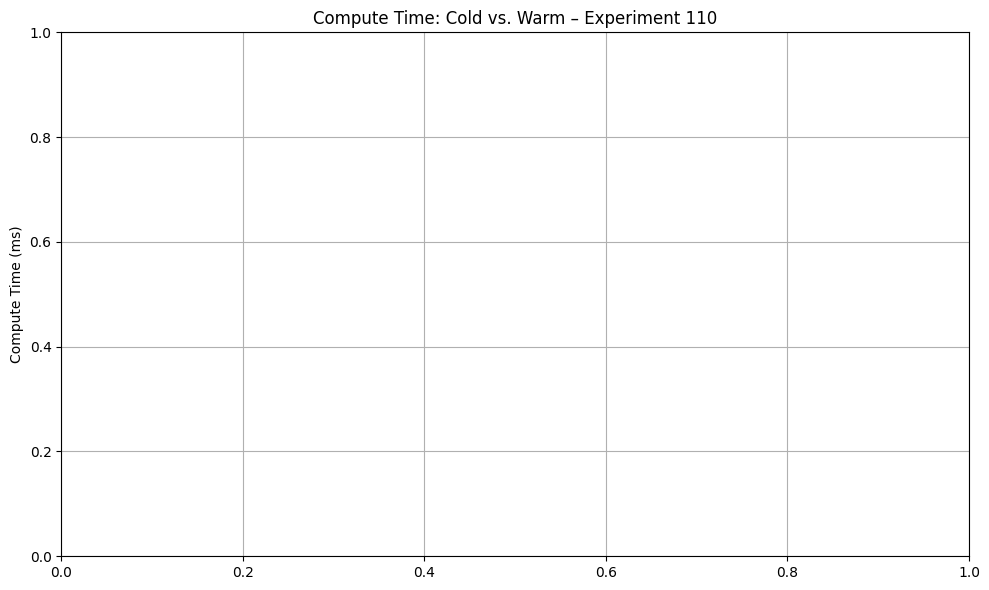

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Nur Experiment 110 auswählen
exp_code = 110
df_exp = df_clean[df_clean['experiment'] == exp_code]

# Anbieterhäufigkeit anzeigen
print(f"\nExperiment {exp_code}")
print(df_exp['anbieter'].value_counts())

# Schwellenwerte berechnen
thresholds = (
    df_exp.groupby(["anbieter", "aufruf"])["compute_time"]
    .apply(lambda x: x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))
    .reset_index(name="threshold")
)

# Boxplot zeichnen
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exp, x="anbieter", y="compute_time", hue="aufruf")

# Schwellenwerte als rote gestrichelte Linien anzeigen
hue_levels = df_exp["aufruf"].unique()
anbieter_levels = df_exp["anbieter"].unique()

for _, row in thresholds.iterrows():
    anbieter = row["anbieter"]
    aufruf = row["aufruf"]
    thresh = row["threshold"]

    x_base = list(anbieter_levels).index(anbieter)
    hue_index = list(hue_levels).index(aufruf)
    hue_count = len(hue_levels)
    offset = (hue_index - (hue_count - 1) / 2) / hue_count
    x_pos = x_base + offset

    # Linie zeichnen
    plt.hlines(y=thresh, xmin=x_pos - 0.1, xmax=x_pos + 0.1, colors="red", linestyles="--")
    # Optional: Schwellenwert als Text
    plt.text(x_pos, thresh + 2, f"{thresh:.1f}", color="red", ha="center", fontsize=8)

plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
plt.ylabel("Compute Time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [129]:
print(df_clean['experiment'].unique())
print(df_clean[df_clean['experiment'] == 110])


['120' '220' '311']
Empty DataFrame
Columns: [anbieter, aufruf, experiment, datei, request_id, zeit, compute_time, download_time, upload_time, benchmark_time, client_time, failure]
Index: []


In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

exp_code = "110"  # als String
df_exp = df_clean[df_clean['experiment'] == exp_code]

# 2. Nur vollständige Zeilen behalten
df_exp = df_exp.dropna(subset=["anbieter", "compute_time", "aufruf"])

# 3. Sicherstellen, dass Daten für Plot vorhanden sind
if df_exp.empty:
    print(f"[Experiment {exp_code}] Keine gültigen Daten vorhanden.")
else:
    print(f"\nExperiment {exp_code}")
    print(df_exp['anbieter'].value_counts())

    # 4. Schwellenwerte berechnen (ohne group_keys)
    thresholds = []
    grouped = df_exp.groupby(["anbieter", "aufruf"])
    for (anbieter, aufruf), group in grouped:
        if group["compute_time"].empty:
            continue
        q1 = group["compute_time"].quantile(0.25)
        q3 = group["compute_time"].quantile(0.75)
        iqr = q3 - q1
        threshold = q3 + 1.5 * iqr
        thresholds.append({
            "anbieter": anbieter,
            "aufruf": aufruf,
            "threshold": threshold
        })

    thresholds_df = pd.DataFrame(thresholds)

    # 5. Plot erstellen
    plt.figure(figsize=(10, 6))
    try:
        sns.boxplot(data=df_exp, x="anbieter", y="compute_time", hue="aufruf")
    except ValueError as e:
        print("Fehler beim Zeichnen des Boxplots:", e)
    else:
        # 6. Schwellenwerte einzeichnen
        hue_levels = df_exp["aufruf"].dropna().unique()
        anbieter_levels = df_exp["anbieter"].dropna().unique()

        for _, row in thresholds_df.iterrows():
            anbieter = row["anbieter"]
            aufruf = row["aufruf"]
            thresh = row["threshold"]

            x_base = list(anbieter_levels).index(anbieter)
            hue_index = list(hue_levels).index(aufruf)
            hue_count = len(hue_levels)
            offset = (hue_index - (hue_count - 1) / 2) / hue_count
            x_pos = x_base + offset

            plt.hlines(y=thresh, xmin=x_pos - 0.1, xmax=x_pos + 0.1, colors="red", linestyles="--")
            plt.text(x_pos, thresh + 2, f"{thresh:.1f}", color="red", ha="center", fontsize=8)

        plt.title(f"Compute Time: Cold vs. Warm – Experiment {exp_code}")
        plt.ylabel("Compute Time (ms)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


[Experiment 110] Keine gültigen Daten vorhanden.


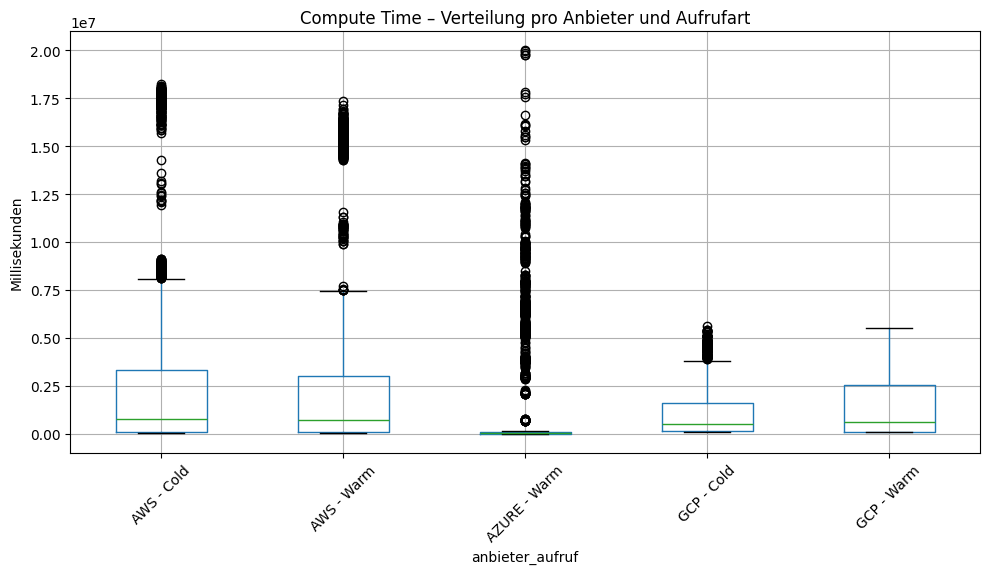

In [131]:
df['anbieter_aufruf'] = df['anbieter'].str.upper() + " - " + df['aufruf'].str.capitalize()

df.boxplot(column="compute_time", by="anbieter_aufruf", figsize=(10, 6))
plt.title("Compute Time – Verteilung pro Anbieter und Aufrufart")
plt.suptitle("")  # optional leer lassen
plt.ylabel("Millisekunden")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
